In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d
import events_utils.tum_vie as tum_dset
import events_utils.flow as flow_utils

from scipy.spatial.transform import Rotation as R

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [186]:
#define time range
t_start = 8.52
duration = 0.1
t_end = t_start + duration
shape_orig = (720, 1280)
dataset = "data/tum-vie-3d/"

In [187]:
events_raw = tum_dset.load_events_time(path + dataset + "mocap-3d-trans-events_right.h5", t_start, t_end)

C:\Users/schiavaz/lava-nc/depth\events_utils\tum_vie.py:38: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  events_h5 = h5py.File(f)["events"]
C:\Users/schiavaz/lava-nc/depth\events_utils\tum_vie.py:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  events_h5 = h5py.File(f)["events"]


3399778 events


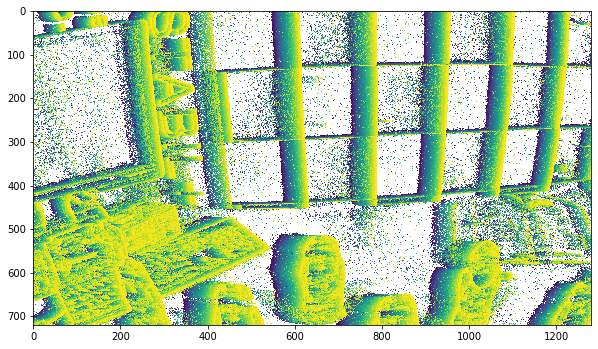

In [188]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_raw, shape_orig, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

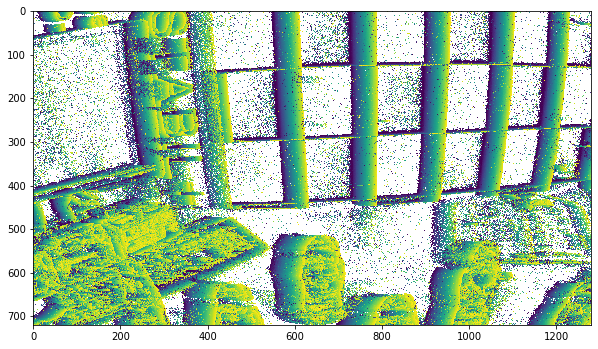

In [189]:
events_ref = flt.filter_refract(events_raw, 0.5)
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_ref, shape_orig, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

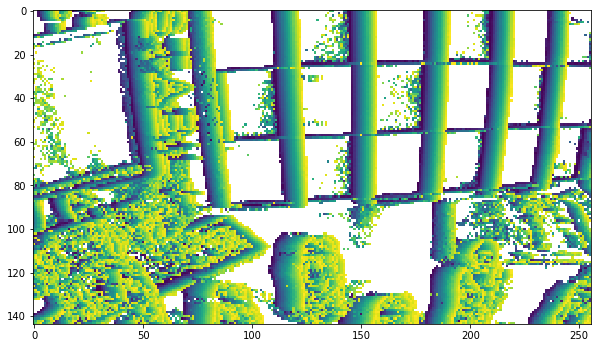

In [190]:
events, shape = flt.filter_conv(events_ref, shape_orig)
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, shape, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

In [191]:
# events = events_ref
# shape = shape_orig

In [192]:
# calib = np.loadtxt(path + dataset + "calib.txt")
focal_length = 1051.3170714099033

In [193]:
poses = tum_dset.load_poses(path + dataset + "mocap_data.txt")

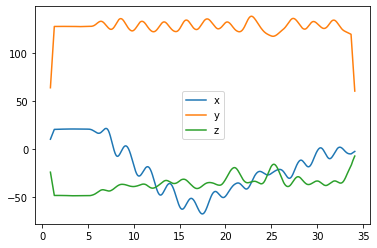

In [194]:
k = np.ones(100)
poses[:,1] = np.convolve(poses[:,1], k, mode="same")
poses[:,2] = np.convolve(poses[:,2], k, mode="same")
poses[:,3] = np.convolve(poses[:,3], k, mode="same")
poses[:,4] = np.convolve(poses[:,4], k, mode="same")
poses[:,5] = np.convolve(poses[:,5], k, mode="same")
poses[:,6] = np.convolve(poses[:,6], k, mode="same")
poses[:,7] = np.convolve(poses[:,7], k, mode="same")

plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
# plt.plot(poses[:,0], poses[:,4], label="q1")
# plt.plot(poses[:,0], poses[:,5], label="q2")
# plt.plot(poses[:,0], poses[:,6], label="q3")
# plt.plot(poses[:,0], poses[:,7], label="q4")
plt.legend()

In [255]:
U, V, std_u, std_v = td2d.measure_td2(events, shape, dist=2, px_range_pred=15, std_thr=0.003, mean_thr=0.002, start_delay=0.02, final_delay=0.07)

100%|█████████████████████████████████████████████████████████████████████████| 60564/60564 [00:03<00:00, 15237.78it/s]


In [256]:
m = np.sqrt(U**2 + V**2)

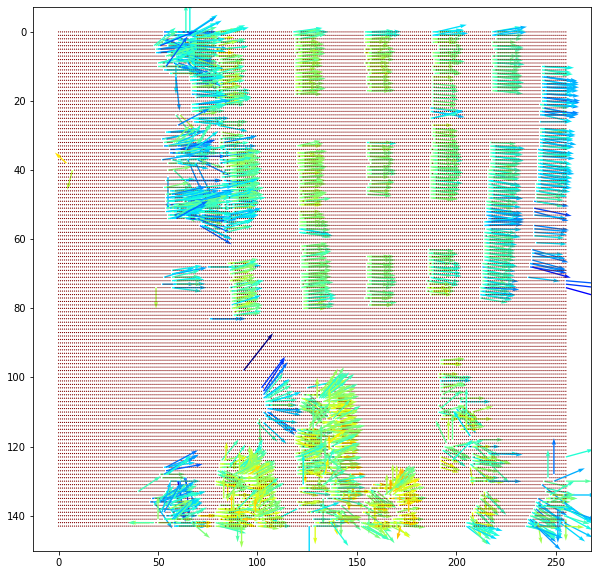

In [257]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(U, V, m, cmap="jet_r")
plt.gca().invert_yaxis()

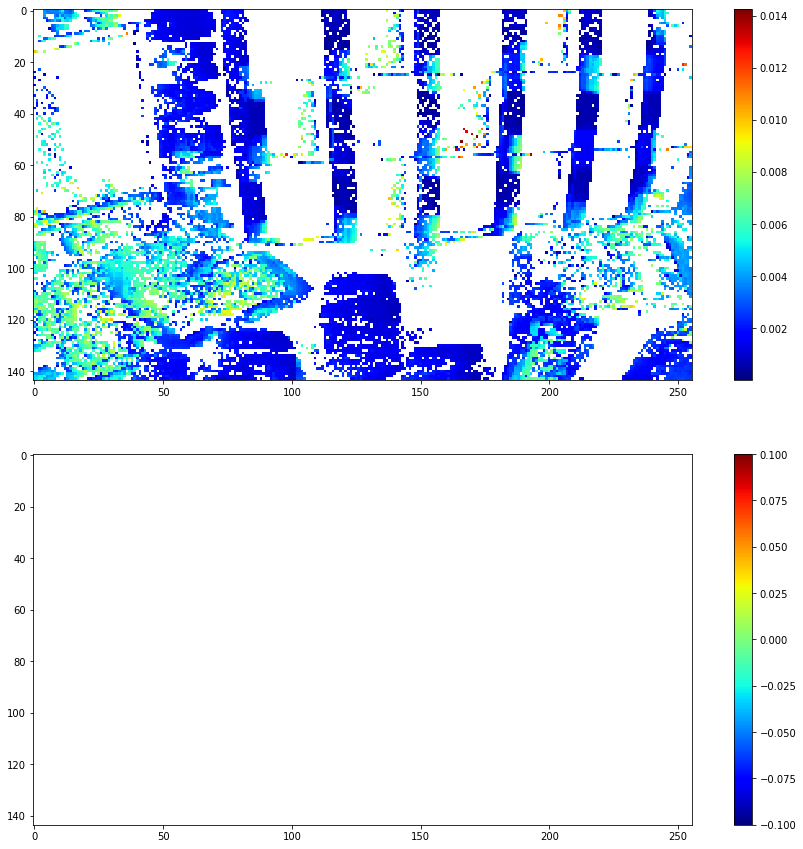

In [258]:
fig, axs = plt.subplots(2, figsize=(15, 15))
U_m = np.ma.masked_where(np.logical_or(std_u >= 0.1, std_u==0.0), std_u)
V_m = np.ma.masked_where(np.logical_or(std_v >= 0.1, std_v==0.0), std_v)
m = axs[0].imshow(U_m, interpolation="none", cmap="jet")
fig.colorbar(m, ax=axs[0])
m = axs[1].imshow(V_m, interpolation="none", cmap="jet")
fig.colorbar(m, ax=axs[1])

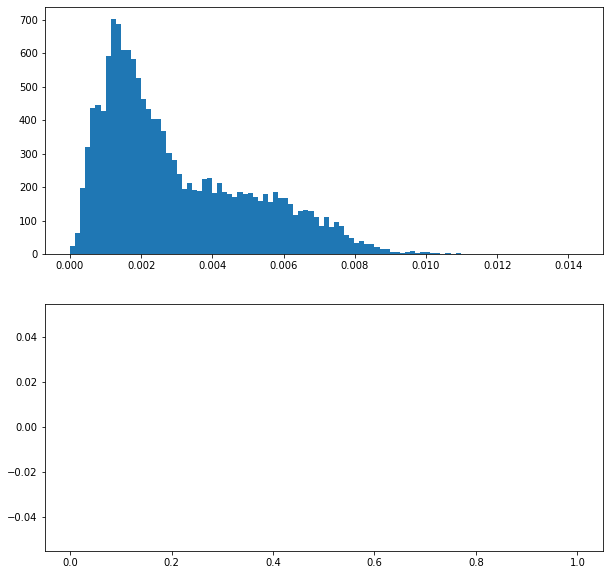

In [259]:
fig, axs = plt.subplots(2, figsize=(10, 10))
U_m = np.ma.masked_where(std_u == 0.0, std_u)
V_m = np.ma.masked_where(std_v == 0.0, std_v)
axs[0].hist(U_m.compressed(), 100);
axs[1].hist(V_m.compressed(), 100);

0.006812500000000554
7.54999999998951e-05
0.007063999999999737
---
0.001671739403129602
0.0025886483996246344
0.0013313012200478925


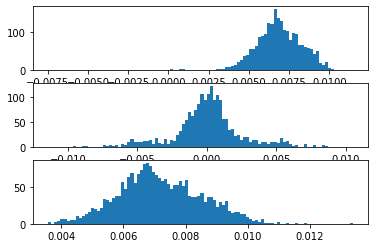

In [260]:
m = np.sqrt(U**2 + V**2)
u_m = np.ma.masked_where(np.isclose(U, 0.0), U)
v_m = np.ma.masked_where(np.isclose(V, 0.0), V)
m_m = np.ma.masked_where(np.isclose(m, 0.0), m)
fig, axs = plt.subplots(3)
axs[0].hist(u_m.compressed(), 100);
axs[1].hist(v_m.compressed(), 100);
axs[2].hist(m_m.compressed(), 100);
# plt.hist(u_m.compressed(), 100);
print(np.median(u_m.compressed()))
print(np.median(v_m.compressed()))
print(np.median(m_m.compressed()))
print("---")
print(np.std(u_m.compressed()))
print(np.std(v_m.compressed()))
print(np.std(m_m.compressed()))

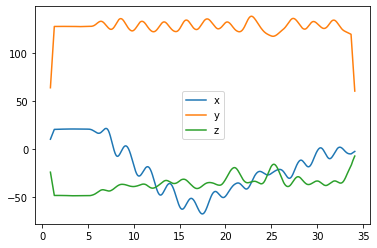

In [261]:
poses = tum_dset.load_poses(path + "data/tum-vie-3d/mocap_data.txt")
k = np.ones(100)
poses[:,1] = np.convolve(poses[:,1], k, mode="same")
poses[:,2] = np.convolve(poses[:,2], k, mode="same")
poses[:,3] = np.convolve(poses[:,3], k, mode="same")
poses[:,4] = np.convolve(poses[:,4], k, mode="same")
poses[:,5] = np.convolve(poses[:,5], k, mode="same")
poses[:,6] = np.convolve(poses[:,6], k, mode="same")
poses[:,7] = np.convolve(poses[:,7], k, mode="same")

plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
# plt.plot(poses[:,0], poses[:,4], label="q1")
# plt.plot(poses[:,0], poses[:,5], label="q2")
# plt.plot(poses[:,0], poses[:,6], label="q3")
# plt.plot(poses[:,0], poses[:,7], label="q4")
plt.legend()

In [262]:
idx = np.searchsorted(poses[:, 0], t_start)
pose1 = poses[idx]
pose2 = poses[idx + 1]

ang1 = R.from_quat(pose1[4:]).as_euler("xyz")
ang2 = R.from_quat(pose2[4:]).as_euler("xyz")

vel = (ang2 - ang1) / (pose2[0] - pose1[0])

print(vel)

[ 0.00097904 -0.01433894  0.09462253]


In [263]:
def get_angular_flow(w, f, shape):
    U_flow = np.zeros(shape)
    V_flow = np.zeros(shape)
    for x in range(U_flow.shape[1]):
        for y in range(U_flow.shape[0]):
            xi = x - 90
            yi = y - 90
            # if np.mod(x, 10) != 0 or np.mod(y, 10) != 0:
            #     continue
            m = np.array([
                [(xi * yi) / f, -(f + xi ** 2 / f), yi],
                [f + yi ** 2 / f, -xi * yi / f, -xi]
            ])
            r = m @ w
            U_flow[y, x] = r[0]
            V_flow[y, x] = r[1]
            
    return U_flow, V_flow

In [264]:
ang_U, ang_V = get_angular_flow(vel, focal_length, shape)

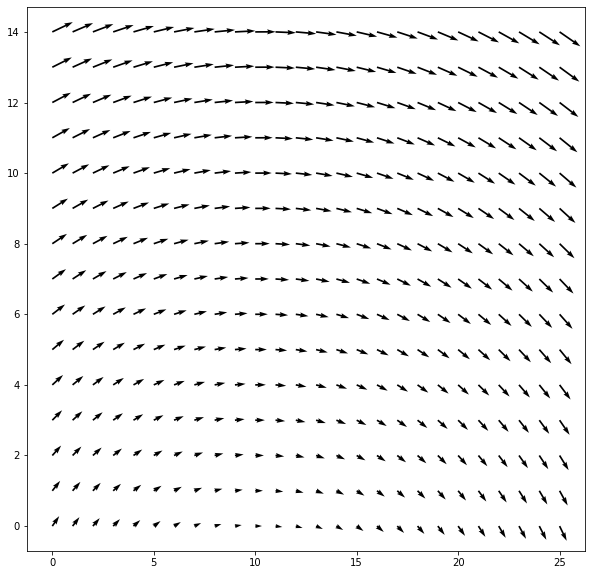

In [265]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(ang_U[::10, ::10], ang_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [266]:
idx = np.searchsorted(poses[:, 0], t_start)
pose1 = poses[idx]
pose2 = poses[idx + 1]

t1 = pose1[1:4]
t2 = pose2[1:4]

print(t1)
print(t2)

t_vel = -(t2 - t1) #/ (pose2[0] - pose1[0])

print(t_vel)
print(pose2[0] - pose1[0])

[ -4.62076533 136.03724539 -37.18812624]
[ -4.47573904 136.05867159 -37.16575691]
[-0.14502629 -0.0214262  -0.02236933]
0.008333000000000368


In [267]:
def get_translational_flow(t, f, shape):
    U_flow = np.zeros(shape)
    V_flow = np.zeros(shape)
    for x in range(U_flow.shape[1]):
        for y in range(U_flow.shape[0]):
            xi = x - 90
            yi = y - 90
            # if np.mod(x, 10) != 0 or np.mod(y, 10) != 0:
            #     continue
            m = np.array([
                [-f, 0, xi],
                [0, -f, yi]
            ])
            r = m @ t
            U_flow[y, x] = r[0]
            V_flow[y, x] = r[1]
            
    return U_flow, V_flow

In [268]:
t_U, t_V = get_translational_flow(t_vel, focal_length, shape)

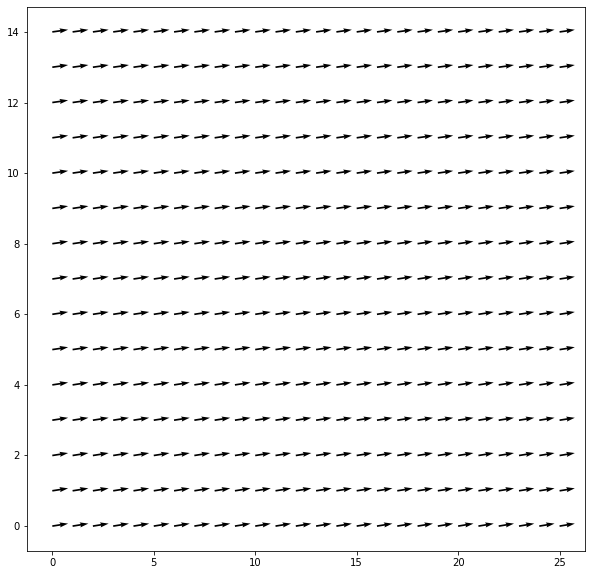

In [269]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(t_U[::10, ::10], t_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [270]:
flow_U = t_U + ang_U
flow_V = t_V + ang_V

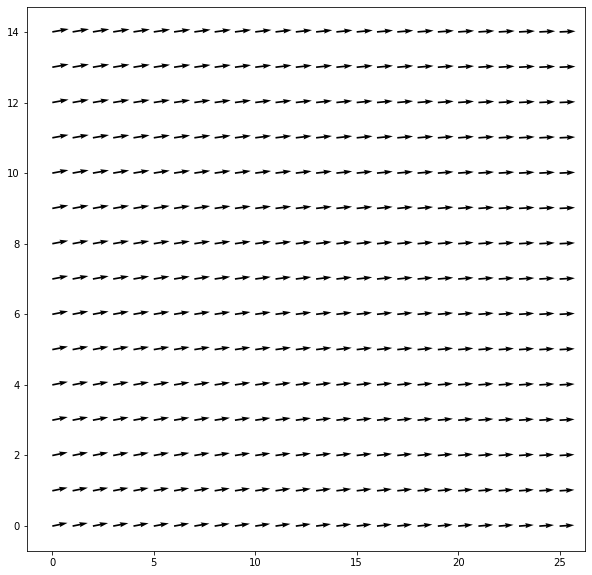

In [271]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(flow_U[::10, ::10], flow_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [272]:
test, test_u, test_v = td2d.extract_depth(shape, U, V, t_U, t_V)

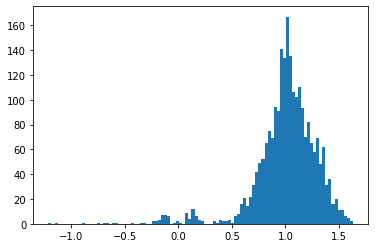

In [273]:
%matplotlib inline
test_m = np.ma.masked_where(np.isclose(test, 0.0), test)
plt.hist(test_m.compressed(), 100);

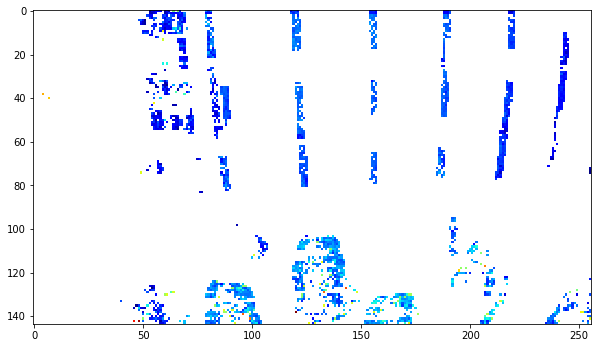

In [274]:
%matplotlib inline
plt.figure(figsize=(10, 10))
# img_gray = plt.imread(path + dataset + "images/frame_00000069.png")
# plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(test_m, interpolation="none", cmap="jet_r")
# plt.colorbar(m)

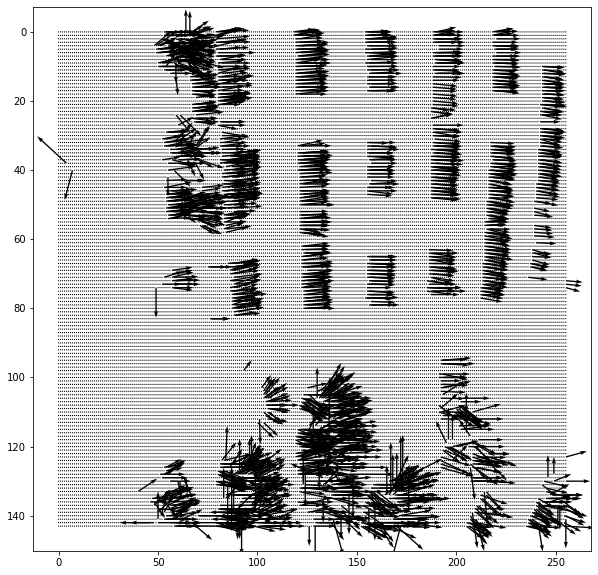

In [275]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(test_u[::1, ::1], test_v[::1, ::1], cmap="jet_r")
plt.gca().invert_yaxis()

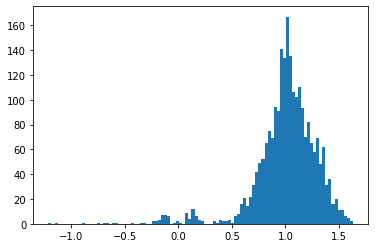

In [276]:
test_m = np.ma.masked_where(test == 0.0, test)
plt.hist(test_m.compressed(), 100);

In [34]:
%matplotlib qt
vis.visualize3d(test_m)